# TD3

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json
import h5py

def load_file(path, name):
    import importlib.util
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

plot = load_file("../../utils/plot.py", "plot")
radam = load_file("../../utils/optim.py", "radam")


cuda = torch.device('cuda')
frame_size = 10
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
# on my system os error often pops up
# try to open the file explorer and copy paste the path again 
# https://drive.google.com/open?id=1pPf-7AmUVceVfgfmKEJ6ireEDKEJHw-7
f = h5py.File("../../data/static_ml20m.hdf5", "r")

In [3]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=2e-1):
        super(Actor, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        # state = self.state_rep(state)
        x = F.relu(self.linear1(state))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x

In [4]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-5):
        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [5]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

def run_tests():
    test_batch = [f[key][n_batches*batch_size:(n_batches+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]
    test_batch = prepare_batch(test_batch)
    losses = td3_update(-1, test_batch, debug=True, learn=False, gamma = P_gamma,
                          soft_tau=P_soft_tau, noise_std=P_noise_std,
                          noise_clip=P_noise_clip, policy_update=P_policy_update)
    return losses
    
    
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

# value, policy, step
def plot_losses(value_losses1, value2_losses, policy_losses, test=True, smoothing=0.5):
    global test_losses
    if test:
        test_ = run_tests()
        test_losses[0].append(test_[0])
        test_losses[1].append(test_[1])
        test_losses[2].append(test_[2])
        test_losses[3].append(len(value1_losses))
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('value')
    plt.plot(smooth(value1_losses, smoothing), label='1 tr')
    #plt.plot(moving_average(value2_losses), label='2 tr')
    plt.plot(test_losses[3], smooth(test_losses[0], smoothing), label='1 te')
    # plt.plot(test_losses[3], test_losses[1], label='2 te')
    plt.legend()
    plt.subplot(132)
    plt.title('policy')
    plt.plot(policy_losses, label='train')
    plt.plot(test_losses[3], test_losses[2], '-r', label='test')
    plt.legend()
    plt.show()

In [7]:
def debug_log_error(name, x):
    global debug_dict
    try:
        target = debug_dict['error'][name] 
    except KeyError:
        if name not in debug_dict['error']:
            debug_dict['error'][name] = {}
            target = debug_dict['error'][name] 
            target['std'] = []
            target['mean'] = []
    
    target['std'].append(x.std().item())
    target['mean'].append(x.mean().item())
    

def debug_log_object(name, x):
    global debug_dict
    debug_dict['obj'][name] = x

def td3_update(step, batch, gamma = 0.99, noise_std = 0.6,
           noise_clip=1, policy_update=3, soft_tau=1e-2, debug=False, learn=True):
    
    state, action, reward, next_state, done = batch
    
    # --------------------------------------------------------#
    # Value Learning
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()), noise_std).to(cuda)
    noise = torch.clamp(noise, -noise_clip, noise_clip)
    next_action += noise
    
    with torch.no_grad():
        target_q_value1  = target_value_net1(next_state, next_action)
        target_q_value2  = target_value_net2(next_state, next_action)
        target_q_value   = torch.min(target_q_value1, target_q_value2)
        expected_q_value = reward + (1.0 - done) * gamma * target_q_value
    
    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    
    debug_log_error('value1', q_value1)
    debug_log_error('value2', q_value2)
    debug_log_object('state', state)
    debug_log_object('action', action)
    debug_log_error('target_value ', target_q_value)
    
    if learn:
        value_optimizer1.zero_grad()
        value_loss1.backward()
        value_optimizer1.step()

        value_optimizer2.zero_grad()
        value_loss2.backward()
        value_optimizer2.step()

    # --------------------------------------------------------#
    # Policy learning

    gen_action = policy_net(state)
    policy_loss = value_net1(state, gen_action)
    policy_loss = -policy_loss.mean()
    
    if learn:
        debug_log_object('gen_action', gen_action)
    else: 
        debug_log_object('test gen_action', gen_action)
        
    # delayed policy update
    if step % policy_update == 0 and learn:
        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), -1, 1)
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=soft_tau)
        soft_update(value_net2, target_value_net2, soft_tau=soft_tau)
    
    losses = [value_loss1.item(), value_loss2.item(), policy_loss.item()]
    return losses

In [8]:
# === TD3 settings ===
P_gamma = 0.99
P_noise_std = 0.1
P_noise_clip = 0.3
P_soft_tau = 0.1
P_policy_lr = 1e-5
P_value_lr  = 1e-5
P_policy_update = 3

P_cfg = {'gamma': P_gamma, 'std': P_noise_std, 'clip':P_noise_clip,
        'stau': P_soft_tau, 'policy_lr': P_policy_lr, 'value_lr': P_value_lr}
# === end ===

In [9]:
test_losses = [[], [], [], []]

value_net1  = Critic(1290, 128, 256).to(cuda)
value_net2 = Critic(1290, 128, 256).to(cuda)
policy_net = Actor(1290, 128, 256).to(cuda)

target_value_net1 = Critic(1290, 128, 256).to(cuda)
target_value_net2 = Critic(1290, 128, 256).to(cuda)
target_policy_net = Actor(1290, 128, 256).to(cuda)

nets =[value_net1, value_net2, policy_net]

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)


value_criterion = nn.MSELoss()

value_optimizer1 = radam.RAdam(value_net1.parameters(), lr=P_value_lr)
value_optimizer2 = radam.RAdam(value_net2.parameters(), lr=P_value_lr)
policy_optimizer = radam.RAdam(policy_net.parameters(), lr=P_policy_lr)

debug_dict = {'error': {}, 'obj': {}}

In [10]:
value1_losses = []
value2_losses = []
policy_losses = [0]

n_epochs = 100
batch_size = 5000
n_batches = (f['done'].shape[0] // batch_size) - 1

batch_bar = tqdm(total=n_batches)
epoch_bar = tqdm(total=n_epochs)

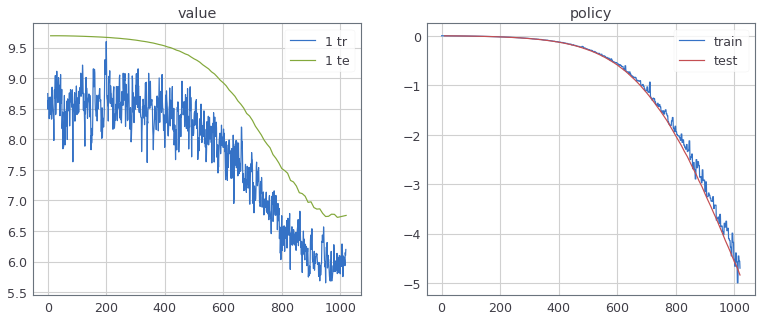

KeyboardInterrupt: 

In [11]:
def prepare_batch(batch):
    
    movies, ratings, done = batch
    movies, ratings, done = [torch.tensor(i.astype('float32')) for i in [movies, ratings, done]]
    movies_tensor = torch.stack([torch.stack([movie_ref[int(i)] for i in ts]) for ts in movies])
    batch_size = done.size(0)
    
    state = torch.cat([movies_tensor[:, :-1, :].view(batch_size, -1), ratings[:, :-1]], 1)
    next_state = torch.cat([movies_tensor[:, 1:, :].view(batch_size, -1), ratings[:, 1:]], 1)
    action = movies_tensor[:, -1]
    reward = ratings[:, -1]
    
    return [i.to(cuda) for i in [state, action, reward, next_state, done]]

# --- config ---
DEBUG = True

step=0
plot_every = 10
# --- end ---

for epoch in range(n_epochs):
    epoch_bar.update(1)
    for i in range(n_batches-1):
        step += 1
        batch_bar.update(1)
        
        batch = [f[key][i*batch_size:(i+1)*batch_size] for key in
                 ['movies', 'ratings', 'done']]
        batch = prepare_batch(batch)
        loss = td3_update(step, batch, debug=DEBUG, gamma = P_gamma,
                          soft_tau=P_soft_tau, noise_std=P_noise_std,
                          noise_clip=P_noise_clip, policy_update=P_policy_update)
        
        value1_losses.append(loss[0])
        value2_losses.append(loss[1])
        
        if step % P_policy_update == 0:
            policy_losses.append(loss[2])
        else:
            policy_losses.append(policy_losses[-1])
        
        batch = []
        
        # debug plotting
        if step % plot_every == 0:
            clear_output(True)
            
            print('step', step)
            # plot.embed_show(debug_dict['obj']['gen_test_action'][:50])
            plot_losses(value1_losses, value2_losses, policy_losses, 0.6)
            
    batch_bar.refresh()

In [19]:
#torch.save(value_net1.state_dict(), "../../models/td3_value_1.pt")
#torch.save(policy_net.state_dict(), "../../models/td3_policy_1.pt")

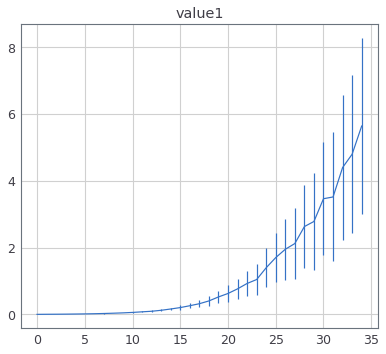

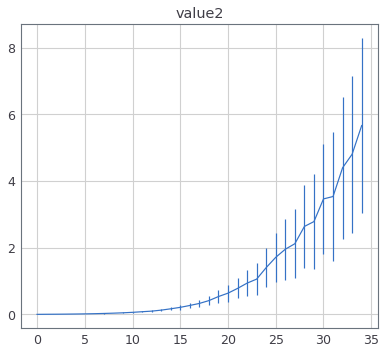

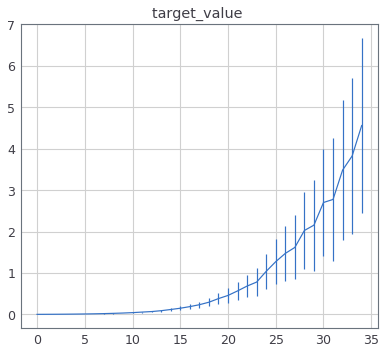

In [12]:
for key, error in debug_dict['error'].items():
    sf = int(np.sqrt(len(error['mean'])))
    plt.errorbar(range(len(error['mean'][::sf])), error['mean'][::sf], error['std'][::sf])
    plt.title(key)
    plt.show()

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


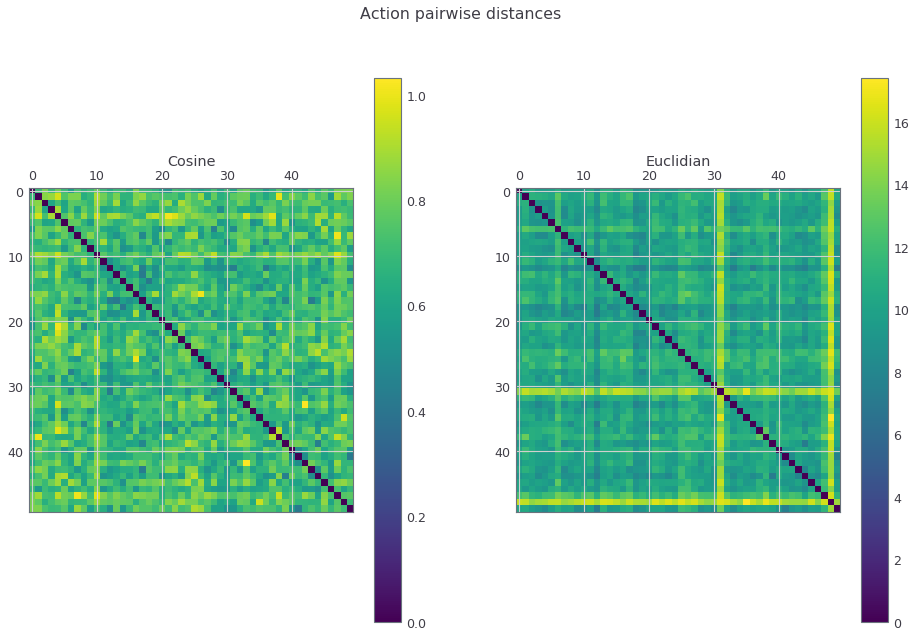

In [13]:
plot.embed_show(debug_dict['obj']['gen_action'][:50])

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


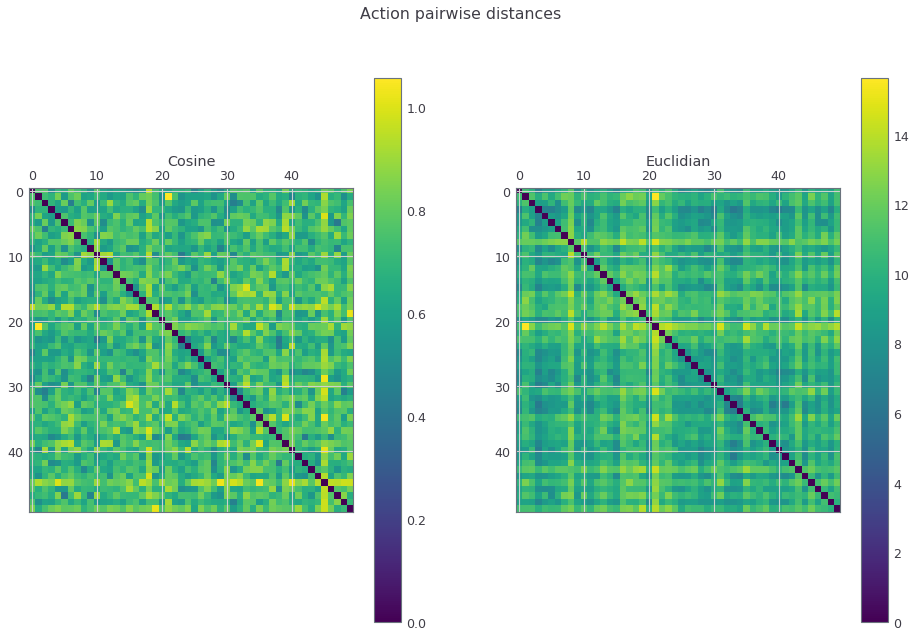

In [14]:
plot.embed_show(debug_dict['obj']['test gen_action'][:50])

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


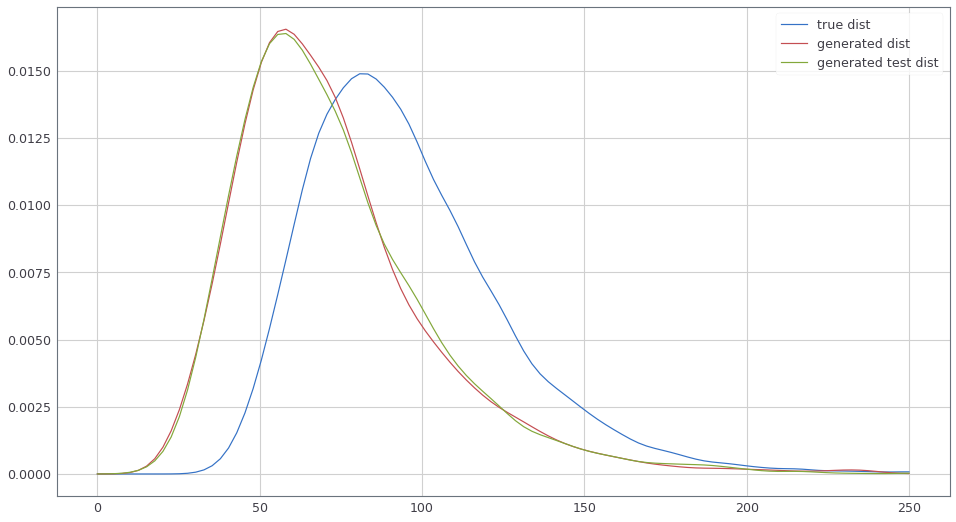

In [17]:

from scipy.special import kl_div
gen_actions = debug_dict['obj']['gen_action']
gen_test_actions = debug_dict['obj']['test gen_action']
true_actions = np.stack([movie_ref[i] for i in movie_ref])


class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.ae = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.ae(x)
    
    def rec_error(self, x):
        error = torch.sum((x - self.ae(x)) ** 2, 1)
        if x.size(1) != 1:
            return error.detach()
        return error.item()
    
ad = AnomalyDetector().to(cuda)
ad.load_state_dict(torch.load('../../models/anomaly.pt'))
ad.eval()

from scipy import stats


true_scores = ad.rec_error(torch.tensor(true_actions).to(cuda).float()).detach().cpu().numpy()
gen_scores = ad.rec_error(torch.tensor(gen_actions).to(cuda).float()).detach().cpu().numpy()
gen_test_scores =ad.rec_error(torch.tensor(gen_test_actions).to(cuda).float()) \
                                                            .detach().cpu().numpy() 

true_kernel = stats.gaussian_kde(true_scores)
gen_kernel = stats.gaussian_kde(gen_scores)
gen_test_kernel = stats.gaussian_kde(gen_test_scores)

x = np.linspace(0,250, 100)
probs_true = true_kernel(x)
probs_gen = gen_kernel(x)
probs_gen_test = gen_test_kernel(x)
plt.figure(figsize=(16, 9))
plt.plot(x, probs_true, '-b', label='true dist')
plt.plot(x, probs_gen, '-r', label='generated dist')
plt.plot(x, probs_gen_test, '-g', label='generated test dist')
plt.legend()
plt.show()